<a href="https://colab.research.google.com/github/ZhengtingHe/DarkSHINE_GAN/blob/main/WGAN_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Hyper parameter

In [6]:
#fake_loss_function = 'binary_crossentropy'
fake_loss_function = 'mse'

energy_cut = 1e-2
#energy_cut = 0

nb_epochs = 10
batch_size = 500
latent_size = 1024

TRAIN_BUF=34025
BATCH_SIZE=batch_size
TEST_BUF=1024
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

#disc_lr = 5e-6
#disc_lr = 5e-7
disc_lr = 2e-5
clas_lr = disc_lr
#disc_lr = 5e-4

gen_lr = 1e-5
#gen_lr = 1e-4
#gen_lr = 5e-4

adam_beta_1 = 0.5

lambda_E = 1e2

E_factor = 0

lambda_sparsity = 10
ELU_alpha = 1e-5


g_pfx = 'params_generator_epoch_'
d_pfx = 'params_discriminator_epoch_'

# Configure

## Import

In [7]:
#import keras
from tensorflow import keras
import keras.backend as K
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from keras.layers import (Input, Dense, Reshape, Conv2D, LeakyReLU,
                          BatchNormalization, LocallyConnected2D, 
                          Activation, ZeroPadding2D, Lambda, Flatten,
                          Embedding, ELU, Dropout, UpSampling2D, Cropping2D
                          )
from keras.layers.merge import add, concatenate, multiply
import time
import h5py
from IPython import display
##MBD import
from keras.engine import InputSpec, Layer
from keras import initializers, regularizers, constraints, activations
from keras.layers import Lambda, ZeroPadding2D, LocallyConnected2D
from keras.layers.merge import concatenate, multiply

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import pandas as pd
from tqdm.autonotebook import tqdm


class Dense3D(Layer):

    """
    A 3D, trainable, dense tensor product layer
    """

    def __init__(self, first_dim,
                 last_dim,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(Dense3D, self).__init__(**kwargs)
        self.first_dim = first_dim
        self.last_dim = last_dim
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(
            shape=(self.first_dim, input_dim, self.last_dim),
            initializer=self.kernel_initializer,
            name='kernel',
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint
        )
        if self.use_bias:
            self.bias = self.add_weight(
                shape=(self.first_dim, self.last_dim),
                initializer=self.bias_initializer,
                name='bias',
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint
            )
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs, mask=None):
        out = K.reshape(K.dot(inputs, self.kernel), (-1, self.first_dim, self.last_dim))
        if self.use_bias:
            out += self.bias
        return self.activation(out)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.first_dim, self.last_dim)

    def get_config(self):
        config = {
            'first_dim': self.first_dim,
            'last_dim': self.last_dim,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(Dense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Instance

In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Apr 26 03:18:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    42W / 300W |    429MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Read HDF5 file

In [9]:
def read_file(particle, infile):
    h5file = h5py.File(infile, 'r')
    ECAL_centre = h5file['ECAL_centre'][:]
    Energy = h5file["Energy"][:]
    sizes = ECAL_centre.shape
    print("There are {} events with {} x {} layout for {}".format(sizes[0], sizes[1], sizes[2],particle))
    y = [particle] * ECAL_centre.shape[0]

    h5file.close()

    return ECAL_centre, Energy, sizes, y

In [10]:
particle_label = {
    #"Inclusive": "/content/drive/MyDrive/Data/dp_ana_Inclusive.hdf5",
    #"GMM_ECAL": "/content/drive/MyDrive/Data/dp_ana_GMM_ECAL.hdf5",
    #"GMM_Target": "/content/drive/MyDrive/Data/dp_ana_GMM_Target.hdf5",
    "PN_ECAL": "/content/drive/MyDrive/Data/dp_ana_PN_ECAL.hdf5",
    #"PN_Target": "/content/drive/MyDrive/Data/dp_ana_PN_Target.hdf5"
}

nb_classes = len(particle_label)
print("There {} types of particles".format(nb_classes))
ECAL_centre, Energy, sizes, y = [
   np.concatenate(t) for t in [
                               a for a in zip(*[read_file(p, f) for p, f in particle_label.items()])
                               ]
   ]

le = LabelEncoder()
y = le.fit_transform(y)
print(list(le.classes_))
ECAL_centre, Energy, y = shuffle(ECAL_centre, Energy, y, random_state=0)
sizes = ECAL_centre.shape

train_images = ECAL_centre.reshape(sizes[0], 20, 20, 1).astype('float32')#The scale of eV should be enough 
train_images = train_images/1000 #Convert to GeV
#train_images = train_images * (train_images>energy_cut)
Energy = Energy.reshape(sizes[0]).astype('float32')
Energy = Energy/1000 #Convert to GeV
print("The shape of tranning data is",train_images.shape)

train_dataset = (
    tf.data.Dataset.from_tensor_slices({
        'images' :train_images, 
        'energy' :Energy
        })
    .shuffle(train_images.shape[0], reshuffle_each_iteration=True)
    .batch(batch_size)
    )

There 1 types of particles
There are 34025 events with 20 x 20 layout for PN_ECAL
['PN_ECAL']
The shape of tranning data is (34025, 20, 20, 1)


# Functions

## Plotting functions

In [12]:
from matplotlib.colors import LogNorm
def plot_2D_image(image, epoch,log=True):    
    fig, ax = plt.subplots(figsize=(5,5))
    if np.max(image)>0:
      energy = ax.imshow(
      image,norm = LogNorm(
          vmin=1e-3,
          vmax=6e3
          )
      )
    else :
      energy = ax.imshow(
      image
      )
    colorbar = fig.colorbar(energy);
    colorbar.set_label(r'Energy (MeV)')
    colorbar.ax.tick_params()
    xticks = range(20)
    yticks = range(20)

    if epoch == -2:
        title = 'Real'
    elif epoch == -1:
        title = 'Counterfeit'
    else:
        title = '2D plot for epoch{:03d}'.format(epoch)
    ax.set_title(title)
    if epoch > -1:
        plt.savefig('2D_image_at_epoch_{:03d}.png'.format(epoch))
    plt.xticks(xticks)
    plt.yticks(yticks)
    plt.show()

def plot_3D_image(image, epoch):
    x_gird = np.arange(0, 20, 1)
    y_gird = np.arange(0, 20, 1)
    X_gird, Y_gird = np.meshgrid(x_gird, y_gird)    
    fig = plt.figure(figsize=(13, 7))
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(X_gird, Y_gird, image, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(r'Energy (MeV)')
    if epoch == -2:
        title = 'Real'
    elif epoch == -1:
        title = 'Counterfeit'
    else:
        title = 'Surface plot for epoch{:04d}'.format(epoch)
    ax.set_title(title)
    fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the energy
    ax.view_init(60, 35)
    if epoch > -1:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

def plot_loss(loss):
    fig=plt.figure(num=1,figsize=(10,10))

    epochs = np.arange(1, len(loss)+1)
    #"d_loss","d_cost", "gp", "g_loss", "g_cost","E_loss"
    d_loss = loss.d_loss.values
    d_cost = loss.d_cost.values
    gp = loss.gp.values
    g_loss = loss.g_loss.values
    g_cost = loss.g_cost.values
    E_loss = loss.E_loss.values


    ax1=fig.add_subplot(221)
    ax1.set_xlabel('Epoch')
    ax1.plot(epochs, d_loss, color='blue', marker='o', label='Discriminator loss')
    ax1.plot(epochs, g_loss, color='red', marker='*',label='Generator loss')
    ax1.grid(axis='y')
    ax1.legend()

    ax2 = fig.add_subplot(222)
    ax2.set_xlabel('Epoch')
    ax2.plot(epochs, d_cost, color='blue', marker='o', label='Discriminator cost')
    ax2.plot(epochs, g_cost, color='red', marker='*',label='Generator cost')
    ax2.grid(axis='y')
    ax2.legend()

    ax3 = fig.add_subplot(223)
    ax3.set_xlabel('Epoch')
    ax3.plot(epochs, E_loss, color='green', marker='D',label='Energy loss')
    ax3.legend()
    ax3.grid(axis='y')
    ax3.set_yscale('log')

    ax4 = fig.add_subplot(224)
    ax4.set_xlabel('Epoch')
    ax4.plot(epochs, gp, color='green', marker='D',label='Gradient Panelty')
    ax4.legend()
    ax4.grid(axis='y')

    plt.show()

## OPS functions

In [13]:
def single_layer_energy(x):
    shape = x.shape
    return K.reshape(K.sum(x, axis=list(range(1, len(shape)))), (-1, 1))


def single_layer_energy_output_shape(input_shape):
    shape = list(input_shape)
    # assert len(shape) == 3
    return (shape[0], 1)


def calculate_energy(x):
    return Lambda(single_layer_energy, single_layer_energy_output_shape, name='Output_energy')(x)

def single_layer_sparsity(x):
    shape = x.shape
    x = K.cast(x>energy_cut, K.floatx())
    return K.reshape(K.sum(x, axis=list(range(1, len(shape)))), (-1, 1))/400

def calculate_sparsity(x):
    return Lambda(single_layer_sparsity, single_layer_energy_output_shape, name='sparsity')(x)

def sparsity_level(x):
    _shape = x.shape
    shape = K.shape(x)
    total = K.cast(K.prod(shape[1:]), K.floatx())
    return K.reshape(K.sum(
        K.cast(x > (energy_cut/1000), K.floatx()), axis=list(range(1, len(_shape)))
    ), (-1, 1)) / total

def sparsity_output_shape(input_shape):
    shape = list(input_shape)
    return (shape[0], 1)

def minibatch_discriminator(x):
    """ Computes minibatch discrimination features from input tensor x"""
    diffs = K.expand_dims(x, 3) - \
        K.expand_dims(K.permute_dimensions(x, [1, 2, 0]), 0)
    l1_norm = K.sum(K.abs(diffs), axis=2)
    return K.sum(K.exp(-l1_norm), axis=2)


def minibatch_output_shape(input_shape):
    """ Computes output shape for a minibatch discrimination layer"""
    shape = list(input_shape)
    assert len(shape) == 3  # only valid for 3D tensors
    return tuple(shape[:2])

def scale(x, v):
    return Lambda(lambda _: _ / v)(x)

def energy_loss_function(input_energy, output_energy):
    energy_redundent = output_energy - input_energy
    energy_gap = input_energy - output_energy
    energy_difference = lambda_E * energy_redundent * K.cast(energy_redundent>0, K.floatx()) + E_factor * energy_gap * K.cast(energy_gap>0, K.floatx())
    loss = K.mean(energy_difference, axis=-1)
    assert len(loss) == 1
    return loss

def energy_gap_function(input_energy, output_energy):
    energy_gap = input_energy - output_energy
    energy_difference = energy_gap * K.cast(energy_gap>0, K.floatx())
    return K.mean(energy_difference, axis=-1)

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def gradient_l2_norm(batch_size, real_images, fake_images):
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # 1. Get the discriminator output for this interpolated image.
        pred = discriminator(interpolated, training=True)

    # 2. Calculate the gradients w.r.t to this interpolated image.
    grads = gp_tape.gradient(pred, [interpolated])[0]
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    #gp = tf.reduce_mean((norm - 1.0) ** 2)
    return norm
    

# Generator and discriminator

## Discriminator

In [14]:
def build_discriminator():

    #Input
    calorimeter = Input(shape=[20,20,1],name='images')
    input_energy = Input(shape=(1,),name='energy')
    discriminator_inputs = [calorimeter, input_energy]

    #CNN
    x = Conv2D(32, (2, 2), padding='same')(calorimeter)
    x = LeakyReLU()(x)

    x = ZeroPadding2D((1, 1))(x)
    #x = LocallyConnected2D(16, (3, 3), padding='valid', strides=(1, 2))(x)
    x = LocallyConnected2D(16, (3, 3), padding='valid', strides=(2, 2))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    x = ZeroPadding2D((1, 1))(x)
    x = LocallyConnected2D(8, (2, 2), padding='valid')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = ZeroPadding2D((1, 1))(x)
    #x = LocallyConnected2D(8, (2, 2), padding='valid', strides=(1, 2))(x)
    x = LocallyConnected2D(8, (2, 2), padding='valid', strides=(2, 2))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    
    minibatch_featurizer = Lambda(minibatch_discriminator,
                                      output_shape=minibatch_output_shape)
    features = [x]
    sparsity_detector = Lambda(sparsity_level, sparsity_output_shape)
    empirical_sparsity = sparsity_detector(calorimeter)
    features.append(empirical_sparsity)
    K_sparsity = Dense3D(10, 10)(empirical_sparsity)
    features.append(Activation('tanh')(minibatch_featurizer(K_sparsity)))

    output_energy = calculate_energy(calorimeter)
    sparsity = calculate_sparsity(calorimeter)
    nb_features = 10
    vspace_dim = 10
    minibatch_featurizer = Lambda(minibatch_discriminator,
                                    output_shape=minibatch_output_shape)
    K_energy = Dense3D(nb_features, vspace_dim)(output_energy)
    #energy_too_big = Lambda(lambda x: 20 * K.cast(x > 8, K.floatx()))(output_energy)
    mbd_energy = Activation('tanh')(minibatch_featurizer(K_energy))
    energy_well = Lambda(lambda x: K.abs(x[0]-x[1]))([output_energy, input_energy])
    #well_too_big = Lambda(lambda x: 10 * K.cast(x > 3, K.floatx()))(energy_well)
    redundent_energy = Lambda(lambda x: x[0]-x[1])([output_energy, input_energy])
    positive_redundent = Lambda(lambda x: K.cast(x > 0, K.floatx()))(redundent_energy)

    p = concatenate([
                    concatenate(features),
                    scale(input_energy, 10),
                    scale(output_energy, 10),
                    #energy_too_big,
                    scale(energy_well, 10),
                    scale(mbd_energy, 10),
                    #well_too_big,
                    redundent_energy,
                    positive_redundent,
                    #sparsity
    ])

    #hidden_layer_1 = Dense(8, activation='sigmoid', name='hidden_layer_1')(p)
    #hidden_layer_2 = Dense(4, activation='sigmoid', name='hidden_layer_2')(hidden_layer_1)
    #fake = Dense(1, activation='sigmoid', name='Real_or_fake')(hidden_layer_2)

    fake = Dense(1, name='Real_or_fake')(p)
    #fake = Dense(1, name='Real_or_fake', activation="sigmoid")(p)
    discriminator_outputs = [fake,
                            output_energy,
                            #sparsity
                            ]

    discriminator = Model(discriminator_inputs, discriminator_outputs, name='Discriminator_model')
    return discriminator

d_model = build_discriminator()
d_model.summary()
#keras.utils.plot_model(d_model)

Model: "Discriminator_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 20, 20, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 20, 20, 32)   160         images[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 20, 20, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 22, 22, 32)   0           leaky_re_lu_4[0][0]              
________________________________________________________________________________

## Generator

In [15]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
    ):
    x = UpSampling2D(up_size)(x)
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
        )(x)

    if use_bn:
        x = BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x

#g_network_type = "UpSampling"
g_network_type = "DownSampling"

def build_generator(nb_rows = 20, nb_cols = 20):
    #Input
    latent = Input(shape=(latent_size, ), name='z')
    input_energy = Input(shape=(1, ), dtype='float32', name='energy')
    generator_inputs = [latent, input_energy]

    h = Lambda(lambda x: x[0] * x[1])([latent, input_energy])

    #Network

    if g_network_type == "UpSampling":

        x = Dense(3 * 3 * 256, use_bias=False)(h)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Reshape((3, 3, 256))(x)
        x = upsample_block(
            x,
            128,
            LeakyReLU(0.2),
            strides=(1, 1),
            use_bias=False,
            use_bn=True,
            padding="same",
            use_dropout=False,
        )
        x = upsample_block(
            x,
            64,
            LeakyReLU(0.2),
            strides=(1, 1),
            use_bias=False,
            use_bn=True,
            padding="same",
            use_dropout=False,
        )
        #x = upsample_block(x, 1, Activation("sigmoid"), strides=(1, 1), use_bias=False, use_bn=True)
        #x = Lambda(lambda x: 8*x)(x)

        x = upsample_block(
            x, 1, Activation("softplus"), strides=(1, 1), use_bias=False, use_bn=True
        )
        image = Cropping2D((2, 2))(x)
    
    else :

        x = Dense((nb_rows + 2) * (nb_cols + 2) * 36)(h)
        x = Reshape((nb_rows + 2, nb_cols + 2, 36))(x)

        x = Conv2D(16, (2, 2), padding='same', kernel_initializer='he_uniform')(x)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)

        x = LocallyConnected2D(6, (2, 2), kernel_initializer='he_uniform')(x)
        x = LeakyReLU()(x)

        x = LocallyConnected2D(1, (2, 2), 
                            #use_bias=False,
                            kernel_initializer='glorot_normal'
                            #kernel_initializer=initializers.RandomUniform(minval=-0.1, maxval=-0.01, seed=None)
                            #kernel_initializer=initializers.RandomNormal(mean=-10.0, stddev=0.05, seed=None)
                            )(x)

        image = Activation("softplus")(x)
        
        #x = Activation("sigmoid")(x)
        #image = Lambda(lambda x: 8*x)(x)
    
    #Map (0,1) to (0,8) GeV
    #image = Lambda(lambda x: 8*x)(x)

    generator = Model(generator_inputs, image, name='Generator_model')

    return generator

g_model = build_generator()
g_model.summary()
#keras.utils.plot_model(g_model)

Model: "Generator_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  [(None, 1024)]       0                                            
__________________________________________________________________________________________________
energy (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 1024)         0           z[0][0]                          
                                                                 energy[0][0]                     
__________________________________________________________________________________________________
dense (Dense)                   (None, 17424)        17859600    lambda_10[0][0]    

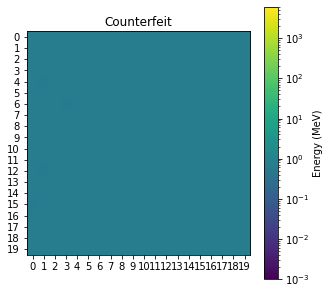

tf.Tensor(
[[277.28992]
 [277.21112]], shape=(2, 1), dtype=float32)


In [16]:
random_latent_vectors = tf.random.normal(shape=(2, latent_size))
real_input_energies = Energy[:2]
g_inputs = {
    'z':random_latent_vectors, 
    'energy':real_input_energies
    }

#g_inputs = [random_latent_vectors, real_input_energies]
fake_images = g_model(g_inputs)
plot_2D_image(fake_images[1,:,:,0],-1)
print(single_layer_energy(fake_images))

# WGAN model

In [17]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=1,
        generator_extra_steps=2,
        gp_weight=10.0,
        E_loss_weight = 10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_size
        self.d_steps = discriminator_extra_steps
        self.g_steps = generator_extra_steps
        self.gp_weight = gp_weight
        self.E_loss_weight = E_loss_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn, E_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.E_loss_fn = E_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images, input_energies):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            d_inputs = [interpolated, input_energies]
            pred, _ = self.discriminator(d_inputs, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, train_data):
        real_images = train_data['images']
        real_input_energies = train_data['energy']

        if isinstance(real_images, tuple):
            real_images = real_images[0]

        
        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            g_inputs = {
                'z':random_latent_vectors, 
                'energy':real_input_energies
                }
            with tf.GradientTape() as tape:
                # Get the logits for the real images
                #d_inputs = [real_images, real_input_energies]
                real_logits, _ = self.discriminator(train_data, training=True)

                # Generate fake images from the latent vector
                fake_images = self.generator(g_inputs, training=True)
                # Get the logits for the fake images
                d_inputs = {
                    'images': fake_images, 
                    'energy': real_input_energies}
                fake_logits, _ = self.discriminator(d_inputs, training=True)
                

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images, real_input_energies)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )
        for i in range(self.g_steps):    
            # Train the generator
            # Get the latent vector
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                # Generate fake images using the generator
                g_inputs = {
                    'z':random_latent_vectors,
                    'energy':real_input_energies}
                generated_images = self.generator(g_inputs, training=True)
                # Get the discriminator logits for fake images
                d_inputs = {
                    'images':generated_images,
                    'energy':real_input_energies
                }
                gen_img_logits, output_energies = self.discriminator(d_inputs, training=True)
                # Calculate the generator loss
                g_cost = self.g_loss_fn(gen_img_logits)
                E_loss = self.E_loss_fn(real_input_energies, output_energies)
        
                g_loss = g_cost + E_loss * self.E_loss_weight

            # Get the gradients w.r.t the generator loss
            gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
            # Update the weights of the generator using the generator optimizer
            self.g_optimizer.apply_gradients(
                zip(gen_gradient, self.generator.trainable_variables)
            )
        return {"d_loss": d_loss,"d_cost": d_cost, "gp": gp,"g_loss": g_loss, "g_cost": g_cost,"E_loss": E_loss}

In [18]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self):
        self.Event = np.random.randint(sizes[0])
        self.seed_noise = np.random.normal(0, 1, (1, latent_size))
        self.seed_energy = np.array(Energy[self.Event]).reshape(1,1)
        self.seed = [self.seed_noise, self.seed_energy]
        self.losses = pd.DataFrame(columns = ["d_loss","d_cost", "gp", "g_loss", "g_cost","E_loss"])

    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save_weights('{0}{1:03d}.hdf5'.format(g_pfx, epoch),
                                    overwrite=True)
        self.model.discriminator.save_weights('{0}{1:03d}.hdf5'.format(d_pfx, epoch),
                                        overwrite=True)
        self.losses.loc[len(self.losses)] = logs
        generated_image = self.model.generator(self.seed)
        test_generated_image = 1000 * generated_image[0,:,:,0]
        display.clear_output(wait=True)
        '''
        if np.min(test_generated_image) != 0 :
            min_non_zero_cell = np.min(test_generated_image[np.nonzero(test_generated_image)])
        else :
            min_non_zero_cell = 0
        print("The min is {}".format(min_non_zero_cell))
        '''
        total_epoch = len(self.losses)
        plot_loss(self.losses)
        test_generated_image = np.where(test_generated_image > energy_cut, test_generated_image, 0)
        plot_3D_image(test_generated_image, total_epoch)
        plot_2D_image(test_generated_image, total_epoch)
        
        

        print("The output energy is ",1000 * single_layer_energy(generated_image))
        print(np.max(test_generated_image))
        print("Logs : ",logs)


In [19]:
generator_optimizer = Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

def energy_loss_function(input_energy, output_energy):
    energy_surplus = output_energy - input_energy
    energy_gap = input_energy - output_energy
    loss =  tf.reduce_mean(tf.where(energy_surplus>0, energy_surplus, 0)) 
    #+ E_factor * tf.reduce_mean(tf.where(energy_gap>0, energy_gap, 0))
    return loss

def energy_loss(input_energy, output_energy):
    return tf.reduce_mean(output_energy - input_energy)

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor()

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=latent_size,
    discriminator_extra_steps=1,
    generator_extra_steps=3,
    E_loss_weight = 10.0
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
    E_loss_fn=energy_loss_function
)

# Train

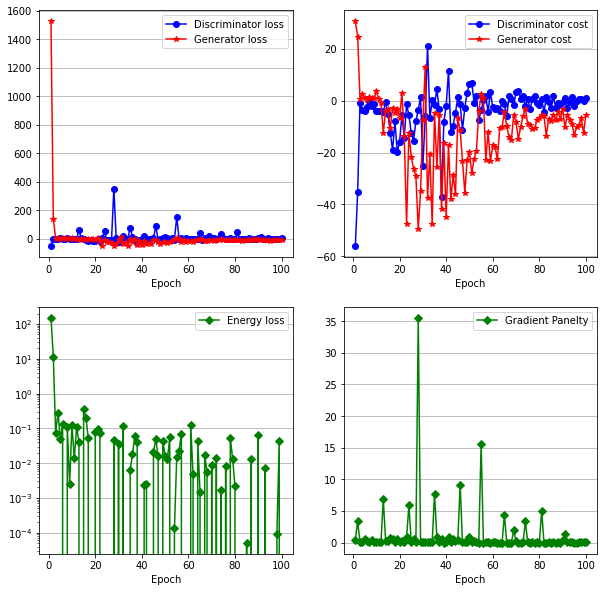

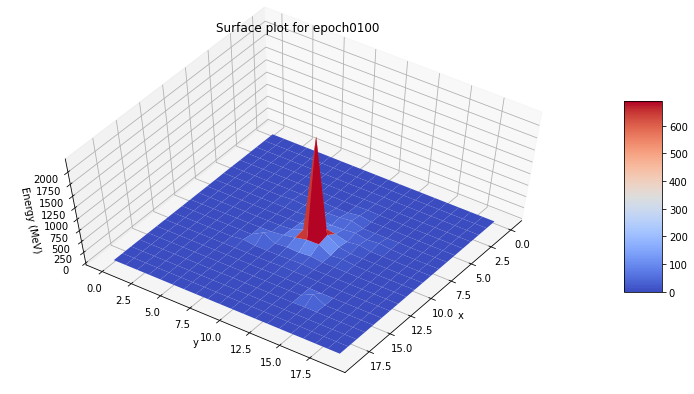

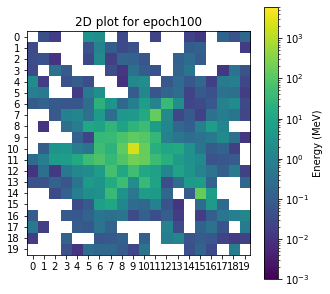

The output energy is  tf.Tensor([[4723.7017]], shape=(1, 1), dtype=float32)
2218.9924
Logs :  {'d_loss': 1.8633664846420288, 'd_cost': 1.1577181816101074, 'gp': 0.07056482881307602, 'g_loss': -5.43057107925415, 'g_cost': -5.43057107925415, 'E_loss': 0.0}


In [56]:
epochs = 50
wgan.fit(train_dataset, batch_size=BATCH_SIZE, epochs=epochs, 
         callbacks=[cbk]
         )

# Load weights

In [15]:
g_model.load_weights("/content/params_generator_epoch_049.hdf5")

# Test model

## Test functions

In [21]:
def heat_map(Input_energy, Output_energy, xbin=70, ybin=70):
    fig = plt.figure(num=1, figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_xlim(0,9000)
    ax.set_ylim(0,9000)
    ax.hist2d(Input_energy, Output_energy, bins=(xbin, ybin), cmap=plt.cm.jet, range=((0,9000),(0,9000)))
    ax.set_xlabel('Input energy (MeV)')
    ax.set_ylabel('Layer energy sum (MeV)')
    plt.show()

def plot_hist(image, bin=50):
    plt.hist(image, bins=bin, alpha=0.75)
    plt.xlabel('Energy (MeV)')
    plt.show()


def plot_compare_hist(real_images, fake_images, title,y_log_scale = True, x_log_scale=False):
    colors = matplotlib.cm.gnuplot2(np.linspace(0.2, 0.8, 3))
    plt.figure(figsize=(10, 10))
    plt.hist(real_images, bins=100,histtype='stepfilled', density=True,linewidth=2,
                alpha=0.2, color=colors[0],
                label=r'GEANT4')
    plt.hist(fake_images, bins=100, histtype='step', density=True,linewidth=3,
                alpha=1, color=colors[0],
                label=r'GAN')
    if y_log_scale:
        plt.yscale('log')
    
    if x_log_scale:
        plt.xscale('log')
    plt.legend(loc='upper right', fontsize=20, ncol=2)
    plt.xlabel(title)
    plt.show()

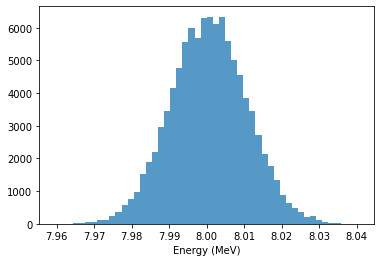

In [22]:
test_size = 100000
test_noise = np.random.normal(0, 1, (test_size, latent_size))
test_sampled_energies = np.random.choice(Energy, test_size)
plot_hist(test_sampled_energies)
test_dataset = (
    tf.data.Dataset.from_tensor_slices({
        'z' :test_noise, 
        'energy' :test_sampled_energies
        })
    .batch(batch_size)
    )

## Test on 8GeV

In [57]:
a = np.arange(1,10)
print(np.where((a>3) & (a<8)))

(array([3, 4, 5, 6]),)


### Generate images

In [58]:
#Use our model to generate image and convert to the scale of MeV
test_generated_image = 1000 * g_model.predict(test_dataset, verbose=1)#GeV -> MeV
#Calculated the energies 
generated_layer_energies = single_layer_energy(test_generated_image)
generated_layer_energies = np.array(generated_layer_energies).reshape(test_size)
True_layer_energy = np.array(single_layer_energy(ECAL_centre)).reshape(sizes[0])
#Test on whether they violate the conservation of energy
min_True_layer_energy = np.min(True_layer_energy)
max_True_layer_energy = np.max(True_layer_energy)
qualified = np.where((generated_layer_energies>min_True_layer_energy)&(generated_layer_energies<max_True_layer_energy))
test_sampled_energies = np.array(test_sampled_energies).reshape(test_size)
qualified_energies = generated_layer_energies[qualified]
print("There are {} qualied samples out of {} samples".format(len(qualified_energies),len(generated_layer_energies)))
test_generated_image = test_generated_image[qualified]
generated_layer_energies = single_layer_energy(test_generated_image)
generated_layer_energies = np.array(generated_layer_energies).reshape(-1)

200/200 [==============================] - 5s 20ms/step
There are 98787 qualied samples out of 100000 samples


### Check random image

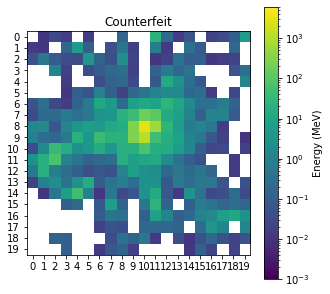

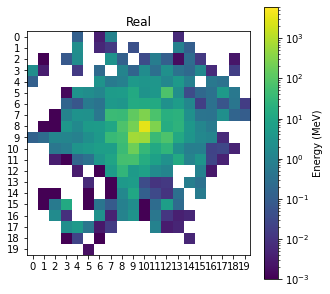

In [59]:
event_num = np.random.randint(len(ECAL_centre))
fake_image = test_generated_image[event_num,:,:,0]
fake_image = np.where(fake_image>energy_cut, fake_image, 0)
plot_2D_image(fake_image, -1)
real_image = ECAL_centre[event_num]
plot_2D_image(real_image,-2)

### Prepare data

In [60]:
original_data = {}
target_data = {}
def recording(name, ori, tar):
    original_data[name] = ori
    target_data[name] = tar

In [61]:
recording('energy', generated_layer_energies,True_layer_energy)

In [62]:
generated_sparsity = (test_generated_image>energy_cut).mean((1,2,3))
true_sparsity = (ECAL_centre>energy_cut).mean((1,2))
#recording('sparsity', generated_sparsity, true_sparsity)

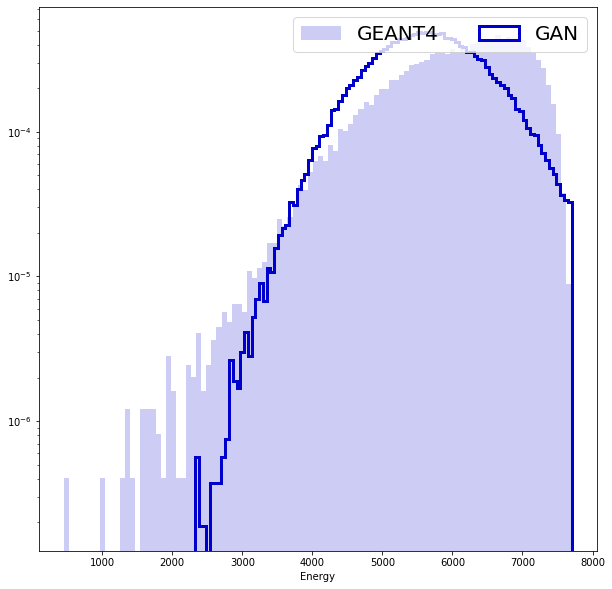

In [63]:
plot_compare_hist(target_data['energy'], original_data['energy'], 'Energy', 
                  #y_log_scale=False
                  )

In [64]:
#plot_compare_hist(target_data['sparsity'], original_data['sparsity'], 'Sparsity')

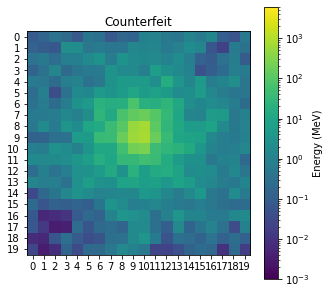

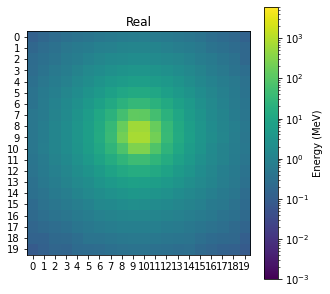

In [65]:
plot_2D_image(np.mean(test_generated_image,axis=0)[:,:,0],-1)
plot_2D_image(np.mean(ECAL_centre,axis=0),-2)

In [66]:
test_generated_image_cut = np.where(test_generated_image[:,:,:,0] > 0, test_generated_image[:,:,:,0], 0)
generated_single_cell = test_generated_image_cut.reshape(np.prod(np.shape(test_generated_image_cut)))
ECAL_cut = np.where(ECAL_centre > 0, ECAL_centre, 0)
ECAL_single_cell = ECAL_cut.reshape(np.prod(np.shape(ECAL_cut)))

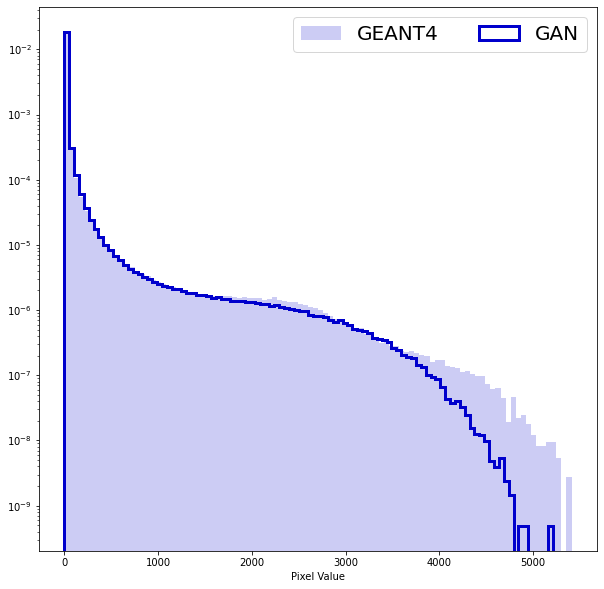

In [67]:
plot_compare_hist(ECAL_single_cell, generated_single_cell, 'Pixel Value')

[-237.5 -212.5 -187.5 -162.5 -137.5 -112.5  -87.5  -62.5  -37.5  -12.5
   12.5   37.5   62.5   87.5  112.5  137.5  162.5  187.5  212.5  237.5]
(400,)


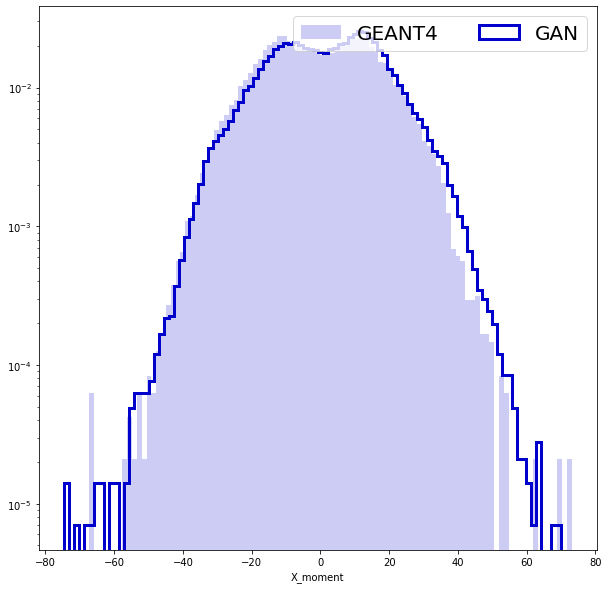

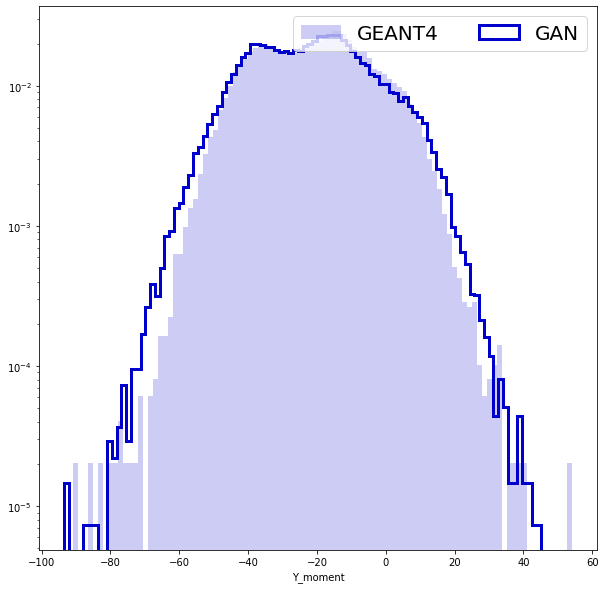

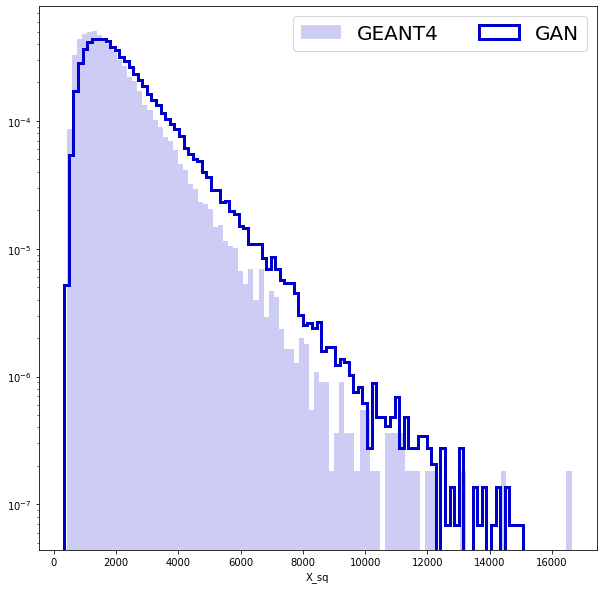

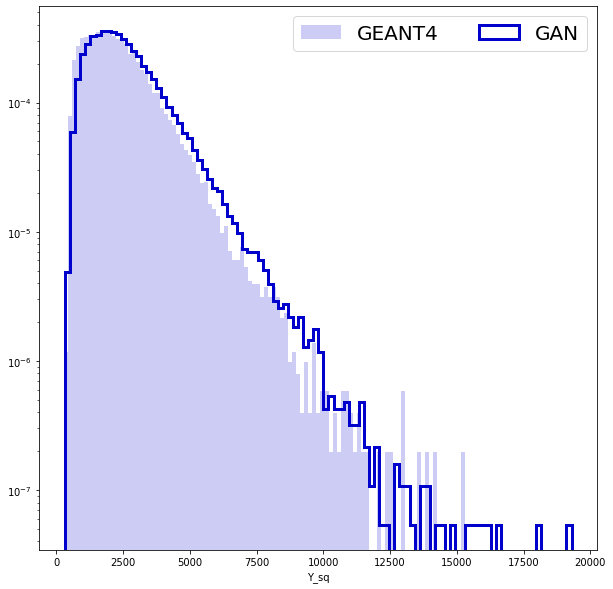

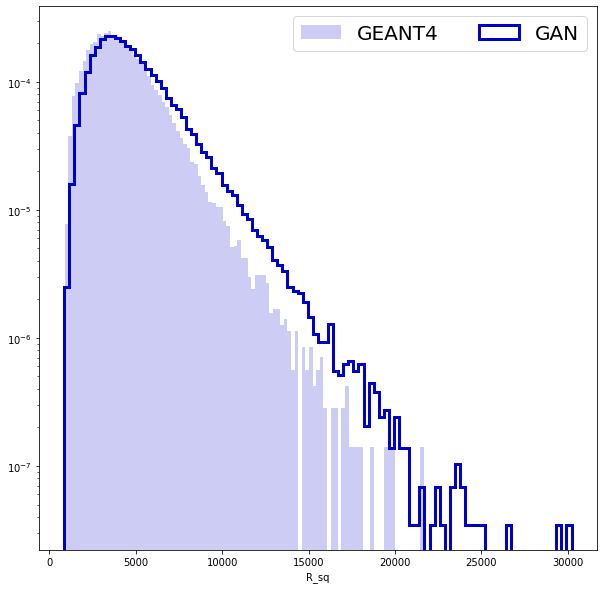

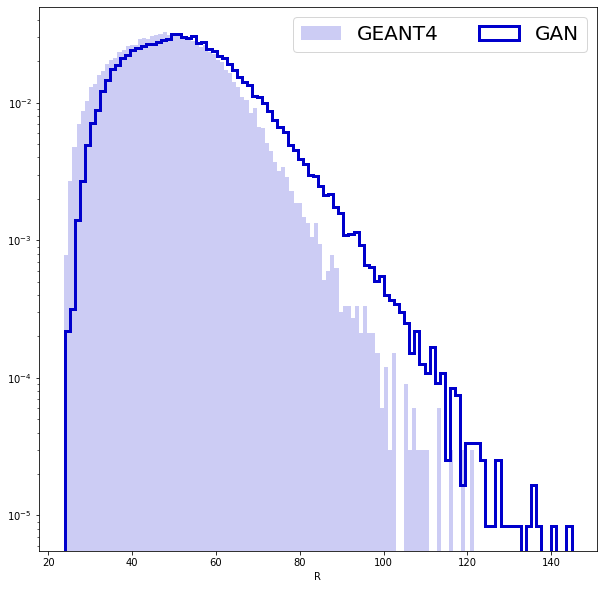

In [68]:
x = 25*np.arange(-9.5,10,1)
y = x
print(x)
x_coor,y_coor = np.meshgrid(x,y,indexing = 'xy')
x_coor = x_coor.reshape(-1)
y_coor = y_coor.reshape(-1)
print(x_coor.shape)
original_energy_weights = test_generated_image.reshape(test_generated_image.shape[0],-1)
target_energy_weights = ECAL_centre.reshape(ECAL_centre.shape[0],-1)

def calculate_variable(variable, name):
    original_variables = np.empty(original_energy_weights.shape[0])
    target_variables = np.empty(target_energy_weights.shape[0])

    for i in range(original_energy_weights.shape[0]):
        original_variables[i] = np.average(variable,weights=original_energy_weights[i])
    
    for i in range(target_energy_weights.shape[0]):
        target_variables[i] = np.average(variable,weights=target_energy_weights[i])

    recording(name, original_variables, target_variables)
calculate_variable(x_coor, 'x_moment')
plot_compare_hist(target_data['x_moment'], original_data['x_moment'], 'X_moment')

calculate_variable(y_coor, 'y_moment')
plot_compare_hist(target_data['y_moment'], original_data['y_moment'], 'Y_moment')

calculate_variable(x_coor**2, 'x_sq')
plot_compare_hist(target_data['x_sq'], original_data['x_sq'], 'X_sq')

calculate_variable(y_coor**2, 'y_sq')
plot_compare_hist(target_data['y_sq'], original_data['y_sq'], 'Y_sq')

calculate_variable(x_coor**2 + y_coor**2, 'r_sq')
plot_compare_hist(target_data['r_sq'], original_data['r_sq'], 'R_sq')

calculate_variable(np.sqrt(x_coor**2 + y_coor**2), 'r')
plot_compare_hist(target_data['r'], original_data['r'], 'R')

In [69]:
'''
def fraction_n(array, n):
    sort = np.sort(array,1)[:,:-(n+1):-1]
    fraction = np.sum(sort, axis=1) / np.sum(array, axis=1)
    return fraction
original_fraction_50 = fraction_n(original_energy_weights, 50)
target_fraction_50 = fraction_n(target_energy_weights, 50)
plot_compare_hist(target_fraction_50, original_fraction_50, 'fraction 50')
recording('fraction_50', original_fraction_50, target_fraction_50)
'''

"\ndef fraction_n(array, n):\n    sort = np.sort(array,1)[:,:-(n+1):-1]\n    fraction = np.sum(sort, axis=1) / np.sum(array, axis=1)\n    return fraction\noriginal_fraction_50 = fraction_n(original_energy_weights, 50)\ntarget_fraction_50 = fraction_n(target_energy_weights, 50)\nplot_compare_hist(target_fraction_50, original_fraction_50, 'fraction 50')\nrecording('fraction_50', original_fraction_50, target_fraction_50)\n"

In [70]:
target = pd.DataFrame(data=target_data)
original = pd.DataFrame(data=original_data)
print(target.columns)
print(original.columns)

Index(['energy', 'x_moment', 'y_moment', 'x_sq', 'y_sq', 'r_sq', 'r'], dtype='object')
Index(['energy', 'x_moment', 'y_moment', 'x_sq', 'y_sq', 'r_sq', 'r'], dtype='object')


# Reweighter

### Install required package

In [38]:
!pip install hep_ml

### Function to plot

In [71]:

from hep_ml.metrics_utils import ks_2samp_weighted
columns = original.columns
KS_data = pd.DataFrame(columns=columns)
def draw_distributions(original, target, new_original_weights, y_log_scale= True, x_log_scale=False):
    KS_values = {}
    colors = matplotlib.cm.gnuplot2(np.linspace(0.2, 0.8, 3))
    plt.figure(figsize=[21, 21])
    for id, column in enumerate(columns, 1):
        xlim = np.percentile(np.hstack([target[column]]), [0.01, 99.99])
        plt.subplot(3, 3, id)

        plt.hist(target[column], bins=100, histtype='stepfilled', density=True,linewidth=2,
                alpha=0.2, color=colors[0],
                label=r'GEANT4')
        plt.hist(original[column], weights=new_original_weights, bins=100, histtype='step', density=True,linewidth=3,
                    alpha=1, color=colors[0],
                    label=r'GAN')
        
        if y_log_scale:
            plt.yscale('log')
    
        if x_log_scale:
            plt.xscale('log')
        plt.title(column)
        print('KS over ', column, ' = ', ks_2samp_weighted(original[column], target[column],
                                                           weights1=new_original_weights, weights2=np.ones(len(target), dtype=float)))
        KS_values[column] = ks_2samp_weighted(original[column], target[column],
                                              weights1=new_original_weights, weights2=np.ones(len(target), dtype=float))
    return KS_values

KS over  energy  =  0.24980855083051812
KS over  x_moment  =  0.04973092919111893
KS over  y_moment  =  0.035258486767438146
KS over  x_sq  =  0.1213099608019374
KS over  y_sq  =  0.07366662613849007
KS over  r_sq  =  0.09509568568589671
KS over  r  =  0.09848130311496017


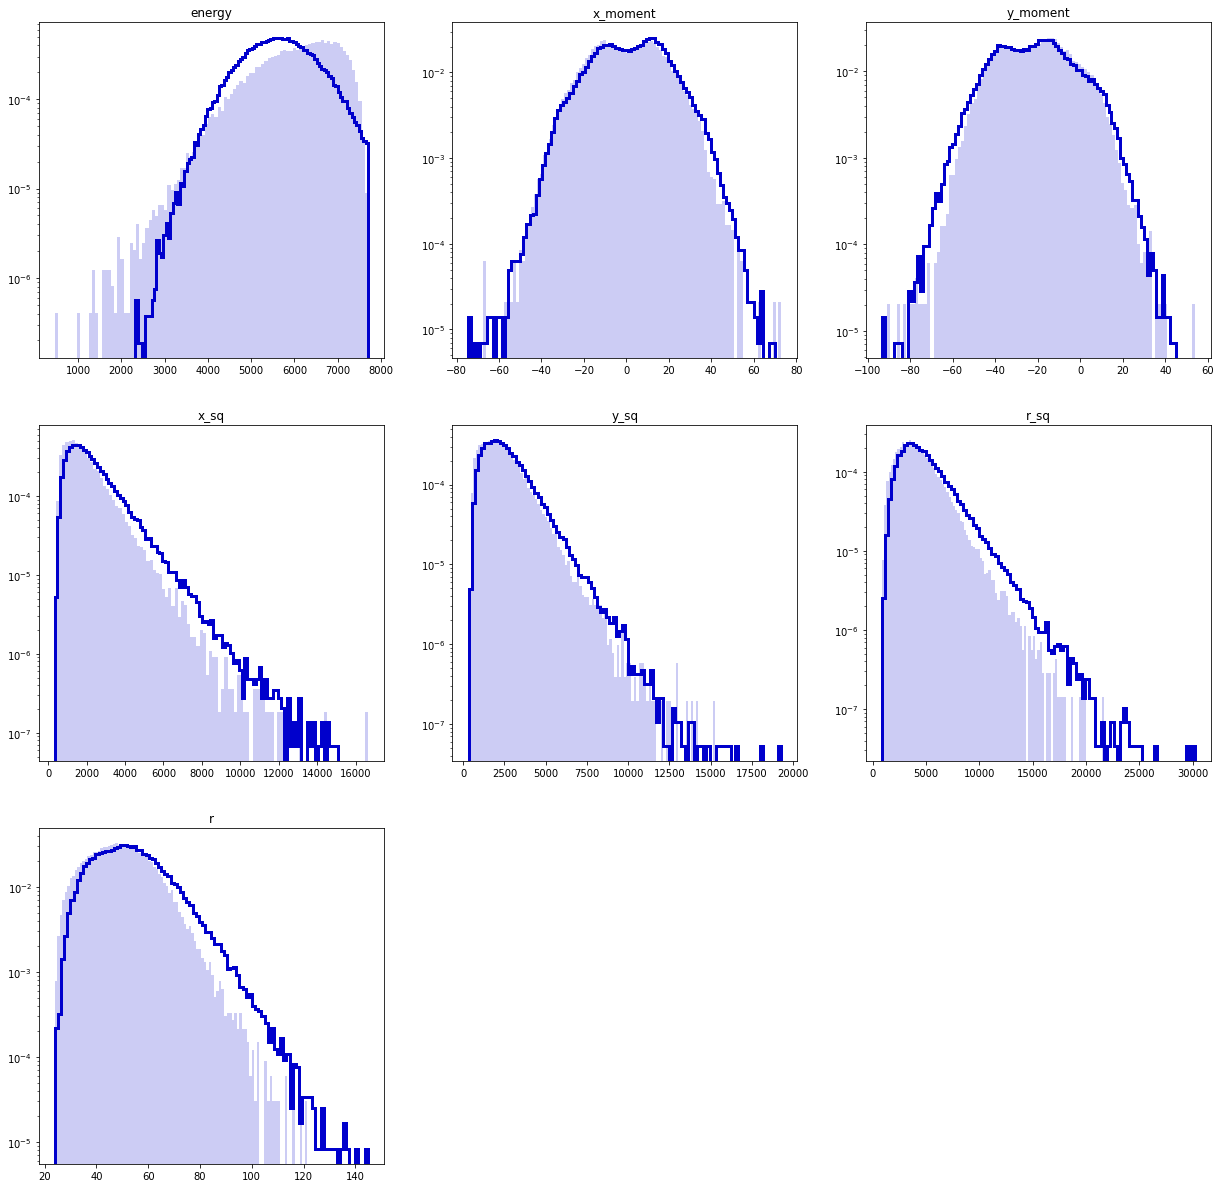

In [72]:
original_weights = np.ones(len(original))
KS_data.loc['original'] = draw_distributions(original, target, original_weights)

## Reweight

In [73]:
from hep_ml import reweight

### Gradient Boosted Reweighter

In [74]:
reweighter = reweight.GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=1000,
                                   gb_args={'subsample': 0.4})

In [75]:
reweighter.fit(original, target)

GBReweighter(gb_args={'subsample': 0.4}, learning_rate=0.1,
             loss_regularization=5.0, max_depth=3, min_samples_leaf=1000,
             n_estimators=50)

In [76]:
gb_weights_test = reweighter.predict_weights(original)

KS over  energy  =  0.022297063131453854
KS over  x_moment  =  0.015630936105288873
KS over  y_moment  =  0.020765603605672367
KS over  x_sq  =  0.02063527044269098
KS over  y_sq  =  0.01603276523219932
KS over  r_sq  =  0.00727631037144949
KS over  r  =  0.01525756582485338


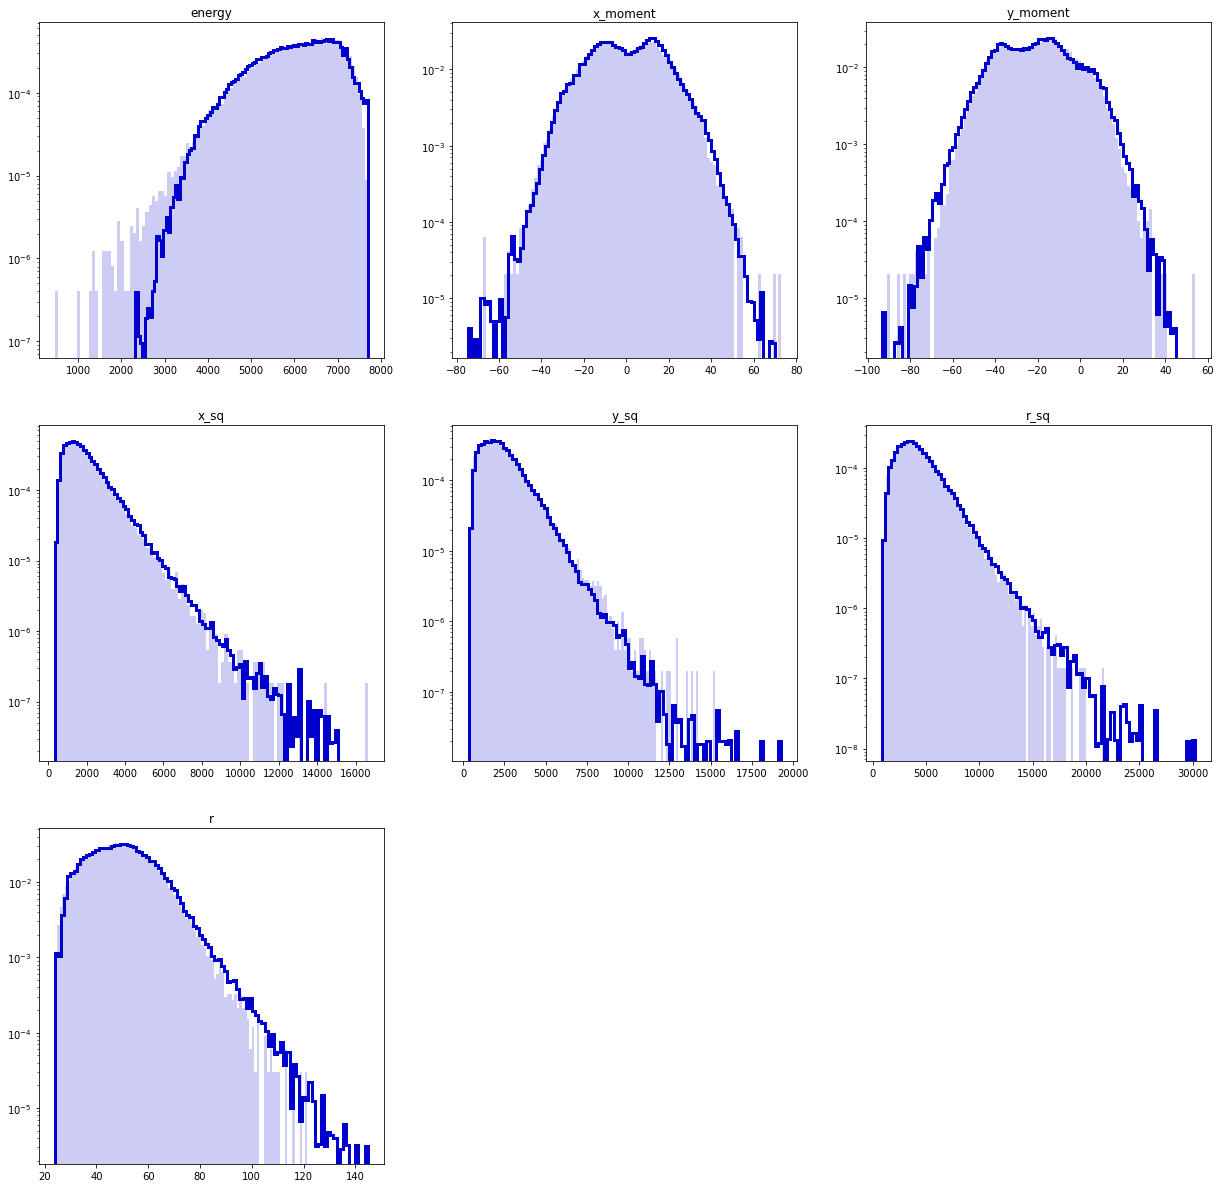

In [77]:
gb_weights_test = reweighter.predict_weights(original)
# validate reweighting rule on the test part comparing 1d projections
KS_data.loc['Gradient Boosted Reweighter'] = draw_distributions(original, target, gb_weights_test)

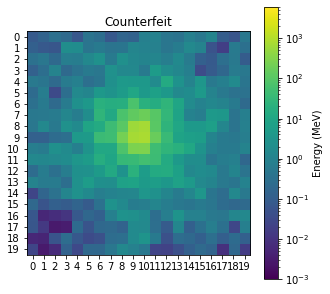

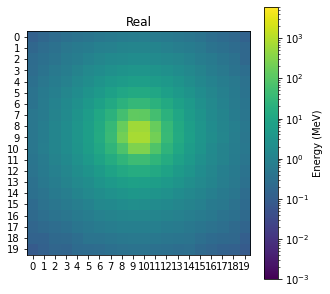

In [78]:
plot_2D_image(np.average(test_generated_image, weights=gb_weights_test,axis=0)[:,:,0],-1)
plot_2D_image(np.mean(ECAL_centre,axis=0),-2)

### Bins-based reweighting in n dimensions

KS over  energy  =  0.0032476877969597195
KS over  x_moment  =  0.12886722195705902
KS over  y_moment  =  0.07551516972294231
KS over  x_sq  =  0.07163565605853262
KS over  y_sq  =  0.06752234894968778
KS over  r_sq  =  0.062094646694830335
KS over  r  =  0.0870265964577745


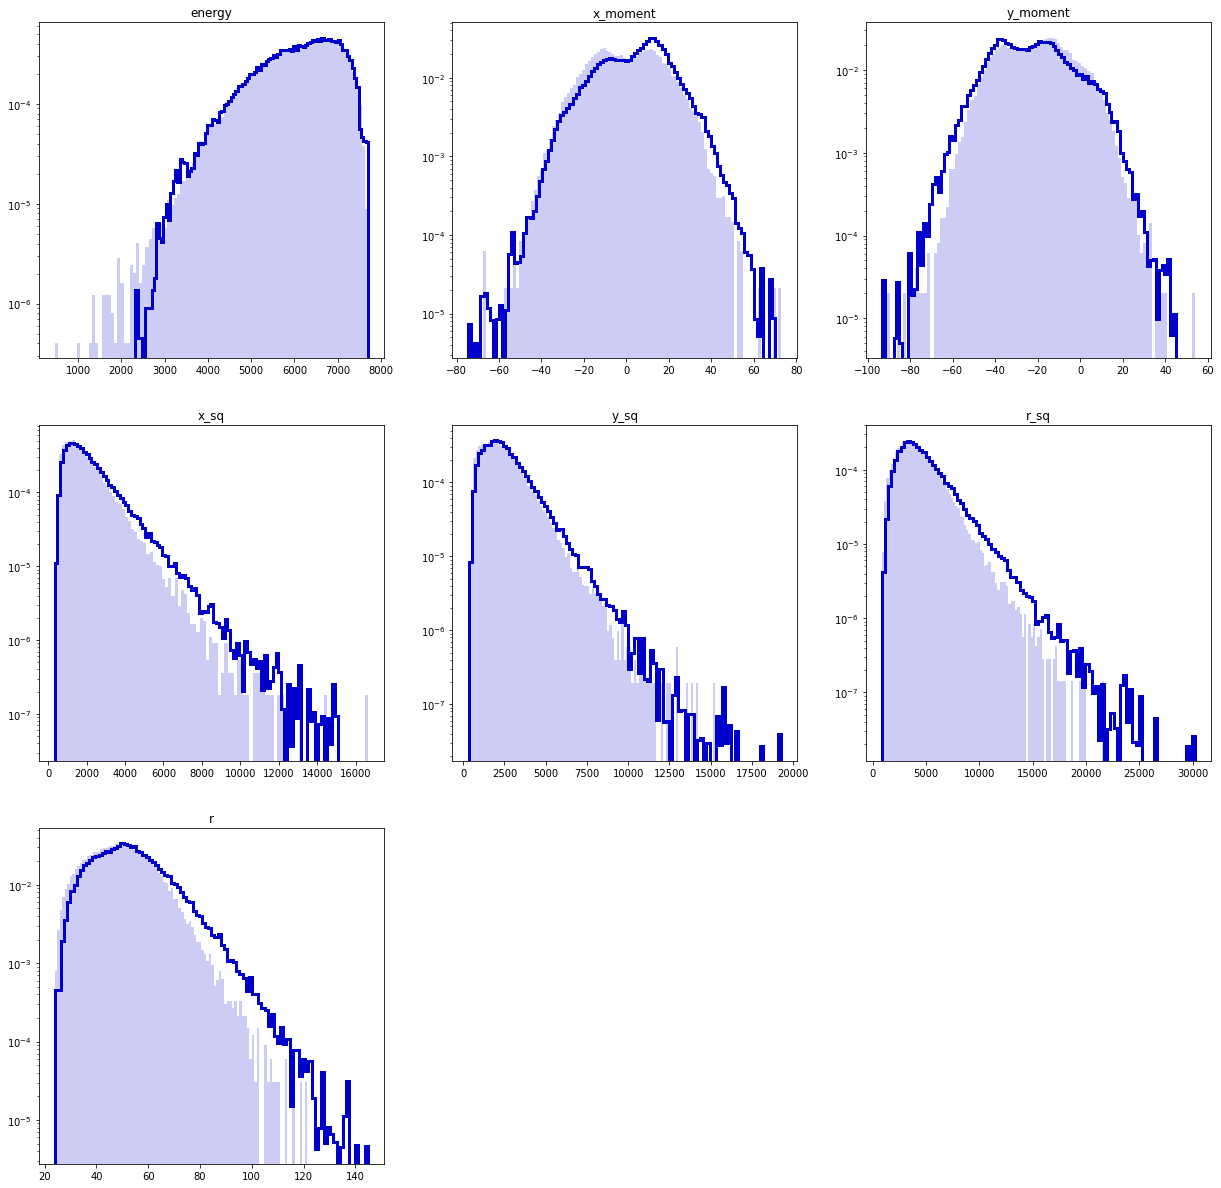

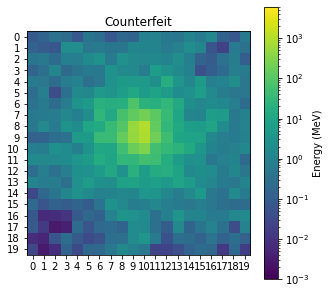

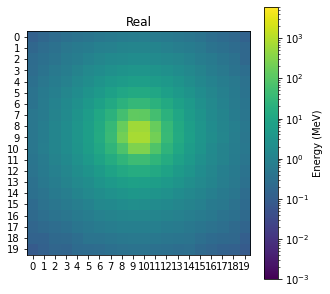

In [79]:
bins_reweighter = reweight.BinsReweighter(n_bins=100, n_neighs=0)
bins_reweighter.fit(original[['energy']], target[['energy']])

bins_weights_test = bins_reweighter.predict_weights(original[['energy']])
# validate reweighting rule on the test part comparing 1d projections
KS_data.loc['Bins-based: energy'] = draw_distributions(original, target, bins_weights_test)
plot_2D_image(np.average(test_generated_image, weights=bins_weights_test,axis=0)[:,:,0],-1)
plot_2D_image(np.mean(ECAL_centre,axis=0),-2)

KS over  energy  =  0.00789273782452931
KS over  x_moment  =  0.13604556583509614
KS over  y_moment  =  0.08214630998438488
KS over  x_sq  =  0.008340645275982328
KS over  y_sq  =  0.045861074975907856
KS over  r_sq  =  0.02456720805054069
KS over  r  =  0.04668292193868423


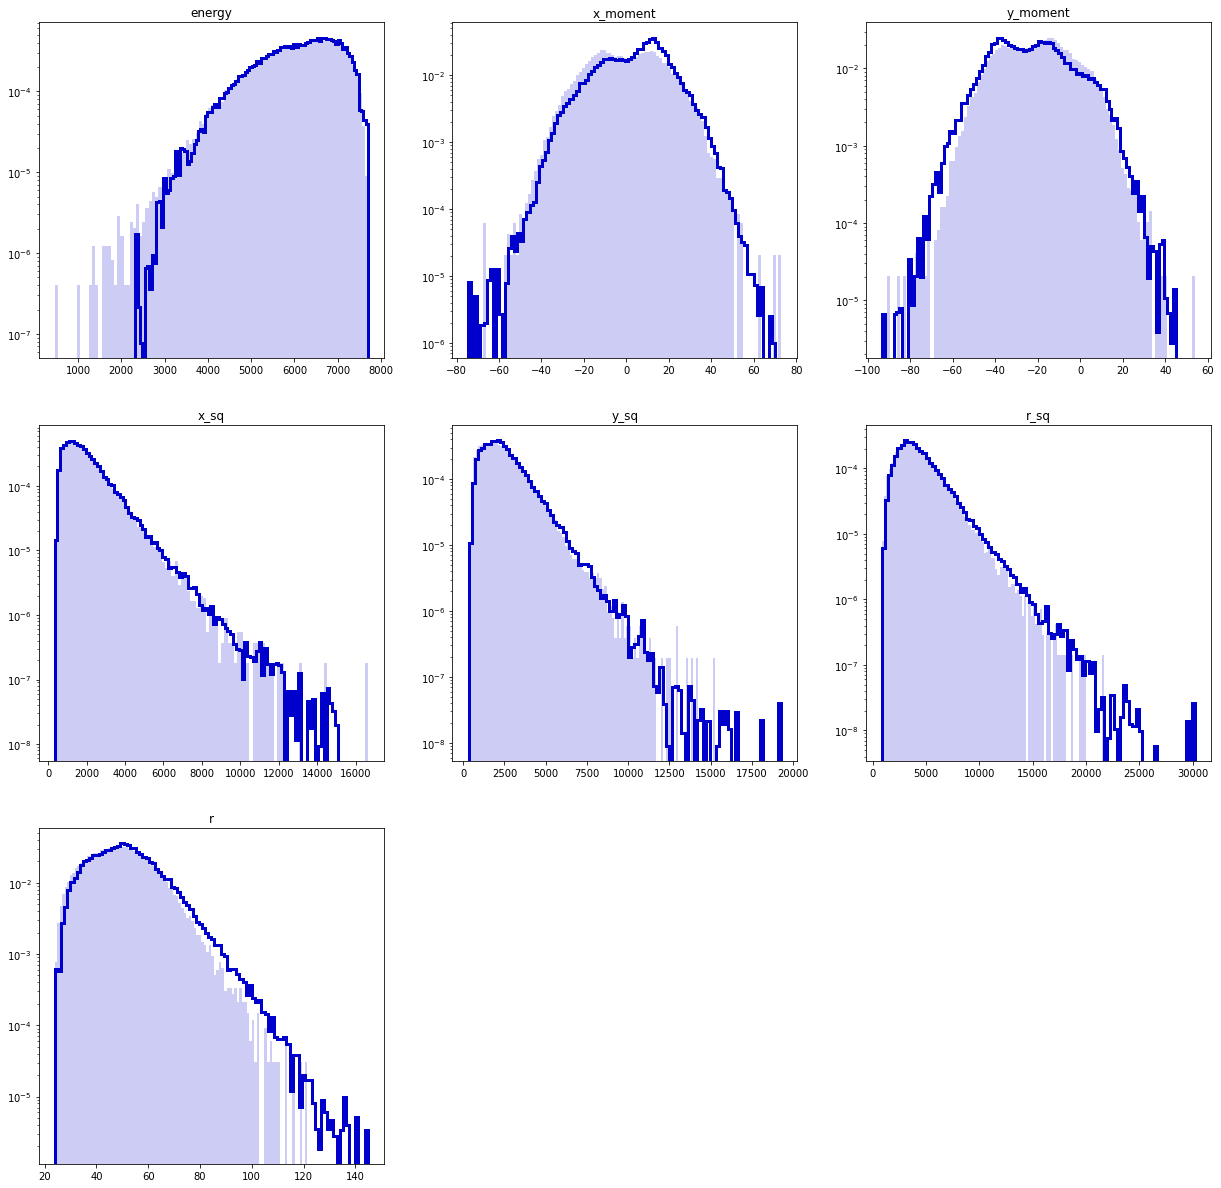

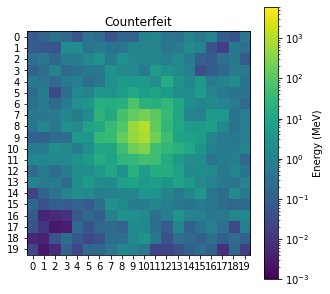

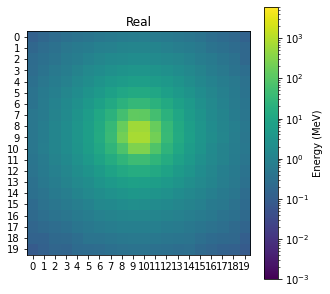

In [80]:
bins_reweighter = reweight.BinsReweighter(n_bins=100, n_neighs=0)
bins_reweighter.fit(original[['energy','x_sq']], target[['energy','x_sq']])

bins_weights_test = bins_reweighter.predict_weights(original[['energy','x_sq']])
KS_data.loc['Bins-based: energy and x_sq'] = draw_distributions(original, target, bins_weights_test)
plot_2D_image(np.average(test_generated_image, weights=bins_weights_test,axis=0)[:,:,0],-1)
plot_2D_image(np.mean(ECAL_centre,axis=0),-2)

### Folding reweighter

KFold prediction using folds column
KS over  energy  =  0.012711492045539119
KS over  x_moment  =  0.017397201268774976
KS over  y_moment  =  0.023204403421084097
KS over  x_sq  =  0.020477292397195646
KS over  y_sq  =  0.011837018553612744
KS over  r_sq  =  0.00836881885492713
KS over  r  =  0.015682847579765458


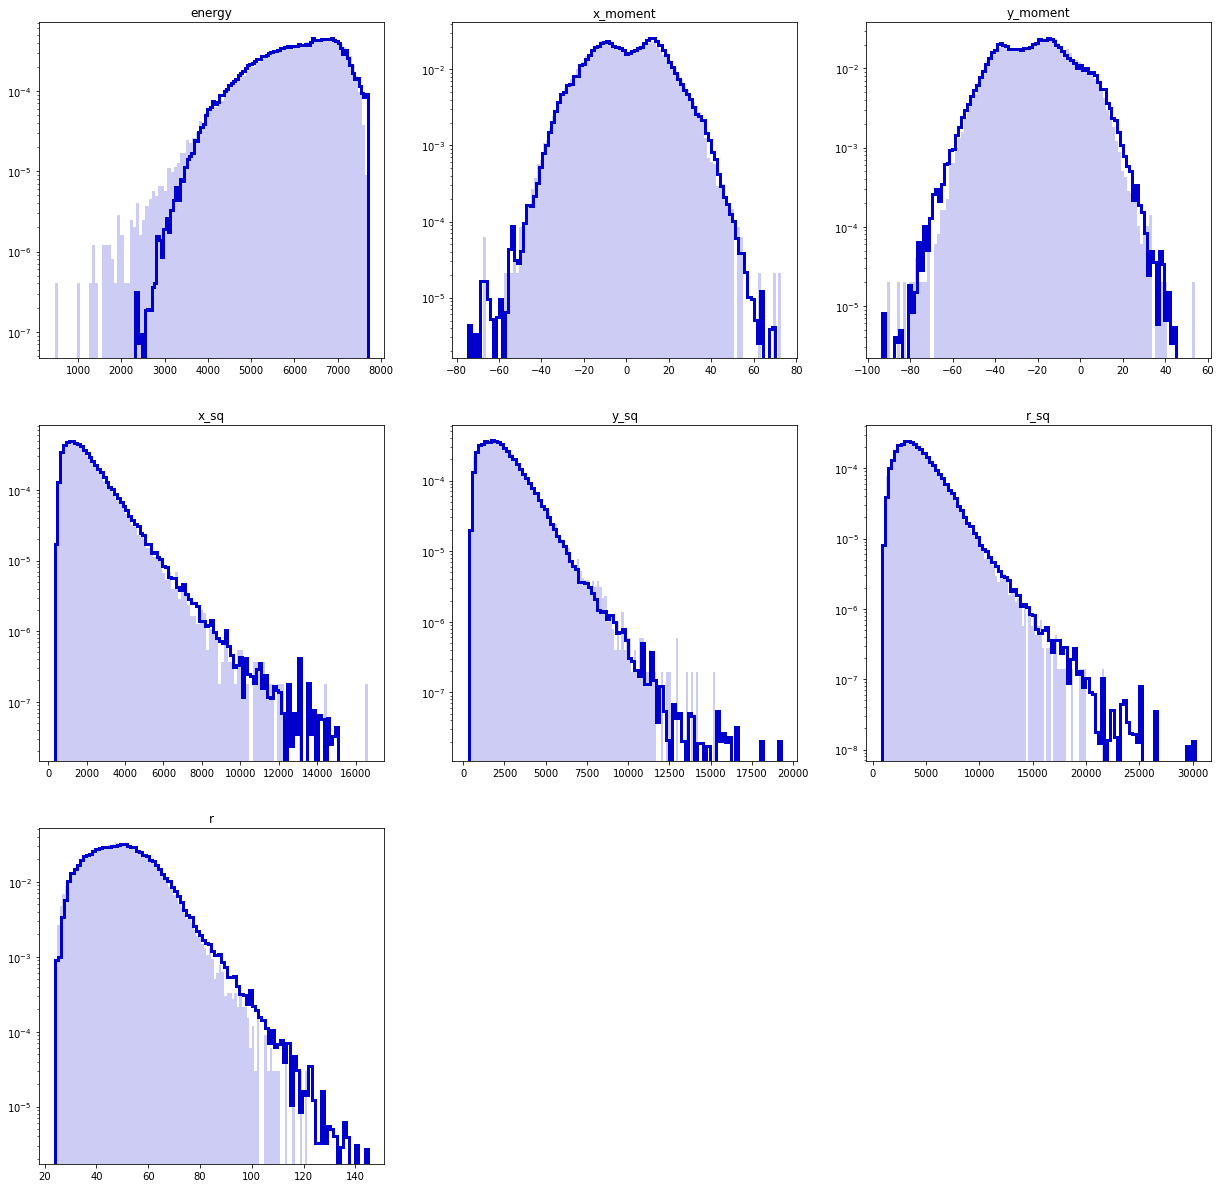

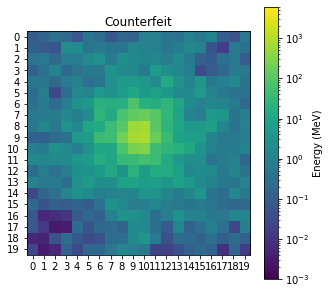

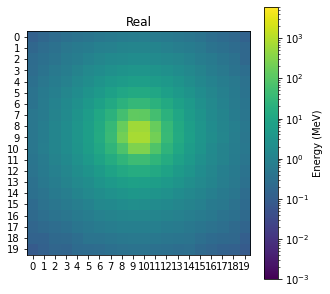

In [81]:
reweighter_base = reweight.GBReweighter(n_estimators=50,
                                        learning_rate=0.1, max_depth=3, min_samples_leaf=1000,
                                        gb_args={'subsample': 0.4})
reweighter = reweight.FoldingReweighter(reweighter_base, n_folds=2)
# it is not needed divide data into train/test parts; rewighter can be train on the whole samples
reweighter.fit(original, target)

# predict method provides unbiased weights prediction for the whole sample
# folding reweighter contains two reweighters, each is trained on one half of samples
# during predictions each reweighter predicts another half of samples not used in training
folding_weights = reweighter.predict_weights(original)

KS_data.loc['Folding reweighter'] = draw_distributions(original, target, folding_weights)
plot_2D_image(np.average(test_generated_image, weights=folding_weights,axis=0)[:,:,0],-1)
plot_2D_image(np.mean(ECAL_centre,axis=0),-2)

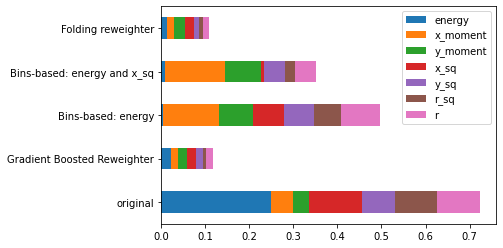

In [82]:
KS_data.plot.barh(stacked=True);

## Classifier

In [73]:
def build_classifier():

    #Input
    calorimeter = Input(shape=[20,20,1],name='images')

    #CNN
    x = Conv2D(32, (2, 2), padding='same')(calorimeter)
    x = LeakyReLU()(x)

    x = ZeroPadding2D((1, 1))(x)
    #x = LocallyConnected2D(16, (3, 3), padding='valid', strides=(1, 2))(x)
    x = LocallyConnected2D(16, (3, 3), padding='valid', strides=(2, 2))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    x = ZeroPadding2D((1, 1))(x)
    x = LocallyConnected2D(8, (2, 2), padding='valid')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = ZeroPadding2D((1, 1))(x)
    #x = LocallyConnected2D(8, (2, 2), padding='valid', strides=(1, 2))(x)
    x = LocallyConnected2D(8, (2, 2), padding='valid', strides=(2, 2))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    
    features = x


    output_energy = calculate_energy(calorimeter)

    p = concatenate([
                    features,
                    output_energy,
                    scale(output_energy, 10)
    ])

    #hidden_layer_1 = Dense(8, activation='relu', name='hidden_layer_1')(p)
    #hidden_layer_2 = Dense(4, activation='relu', name='hidden_layer_2')(hidden_layer_1)
    #fake = Dense(1, activation='sigmoid', name='Real_or_fake')(hidden_layer_2)

    fake = Dense(1, name='Real_or_fake', activation="sigmoid")(p)

    classifier = Model(calorimeter, fake, name='classification')
    return classifier

c_model = build_classifier()
c_model.summary()
c_model.compile(
    optimizer=Adam(lr=clas_lr, beta_1=adam_beta_1),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "classification"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 20, 20, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 20, 20, 32)   160         images[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_10 (LeakyReLU)      (None, 20, 20, 32)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 22, 22, 32)   0           leaky_re_lu_10[0][0]             
_____________________________________________________________________________________

## Training set

In [43]:
print(np.shape(train_images))
print(np.shape(test_generated_image/1000))
image = np.concatenate((train_images, test_generated_image/1000))
print(np.shape(image))
label = np.concatenate((np.ones(np.shape(train_images)[0]),np.zeros(np.shape(test_generated_image)[0])))
print(np.shape(label))

(34116, 20, 20, 1)
(100000, 20, 20, 1)
(134116, 20, 20, 1)
(134116,)


In [45]:
classifier_dataset = (
    tf.data.Dataset.from_tensor_slices((image,label))
    .shuffle(train_images.shape[0], reshuffle_each_iteration=True)
    .batch(batch_size)
    )

## Train

In [74]:
c_model.fit(classifier_dataset,epochs=5)

Epoch 1/5
269/269 [==============================] - 17s 33ms/step - loss: 0.5340 - accuracy: 0.7373
Epoch 2/5
269/269 [==============================] - 9s 33ms/step - loss: 0.4641 - accuracy: 0.8029
Epoch 3/5
269/269 [==============================] - 9s 33ms/step - loss: 0.3662 - accuracy: 0.8594
Epoch 4/5
269/269 [==============================] - 9s 33ms/step - loss: 0.3137 - accuracy: 0.8878
Epoch 5/5
269/269 [==============================] - 9s 32ms/step - loss: 0.2908 - accuracy: 0.8995


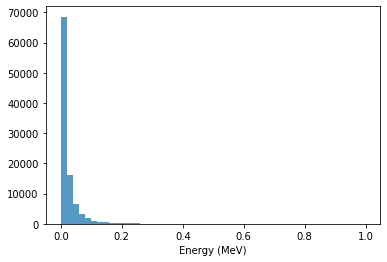

In [75]:
c_model_score = c_model.predict(test_generated_image/1000)
plot_hist(c_model_score)

In [63]:
output_score, output_energy = d_model.predict(((test_generated_image/1000), test_sampled_energies))

KS over  energy  =  0.10954831479045202
KS over  sparsity  =  0.9928608161589304
KS over  x_moment  =  0.04751882523033754
KS over  y_moment  =  0.06348446105216099
KS over  x_sq  =  0.16214585982660396
KS over  y_sq  =  0.02669992813524108
KS over  r_sq  =  0.07901510541648349


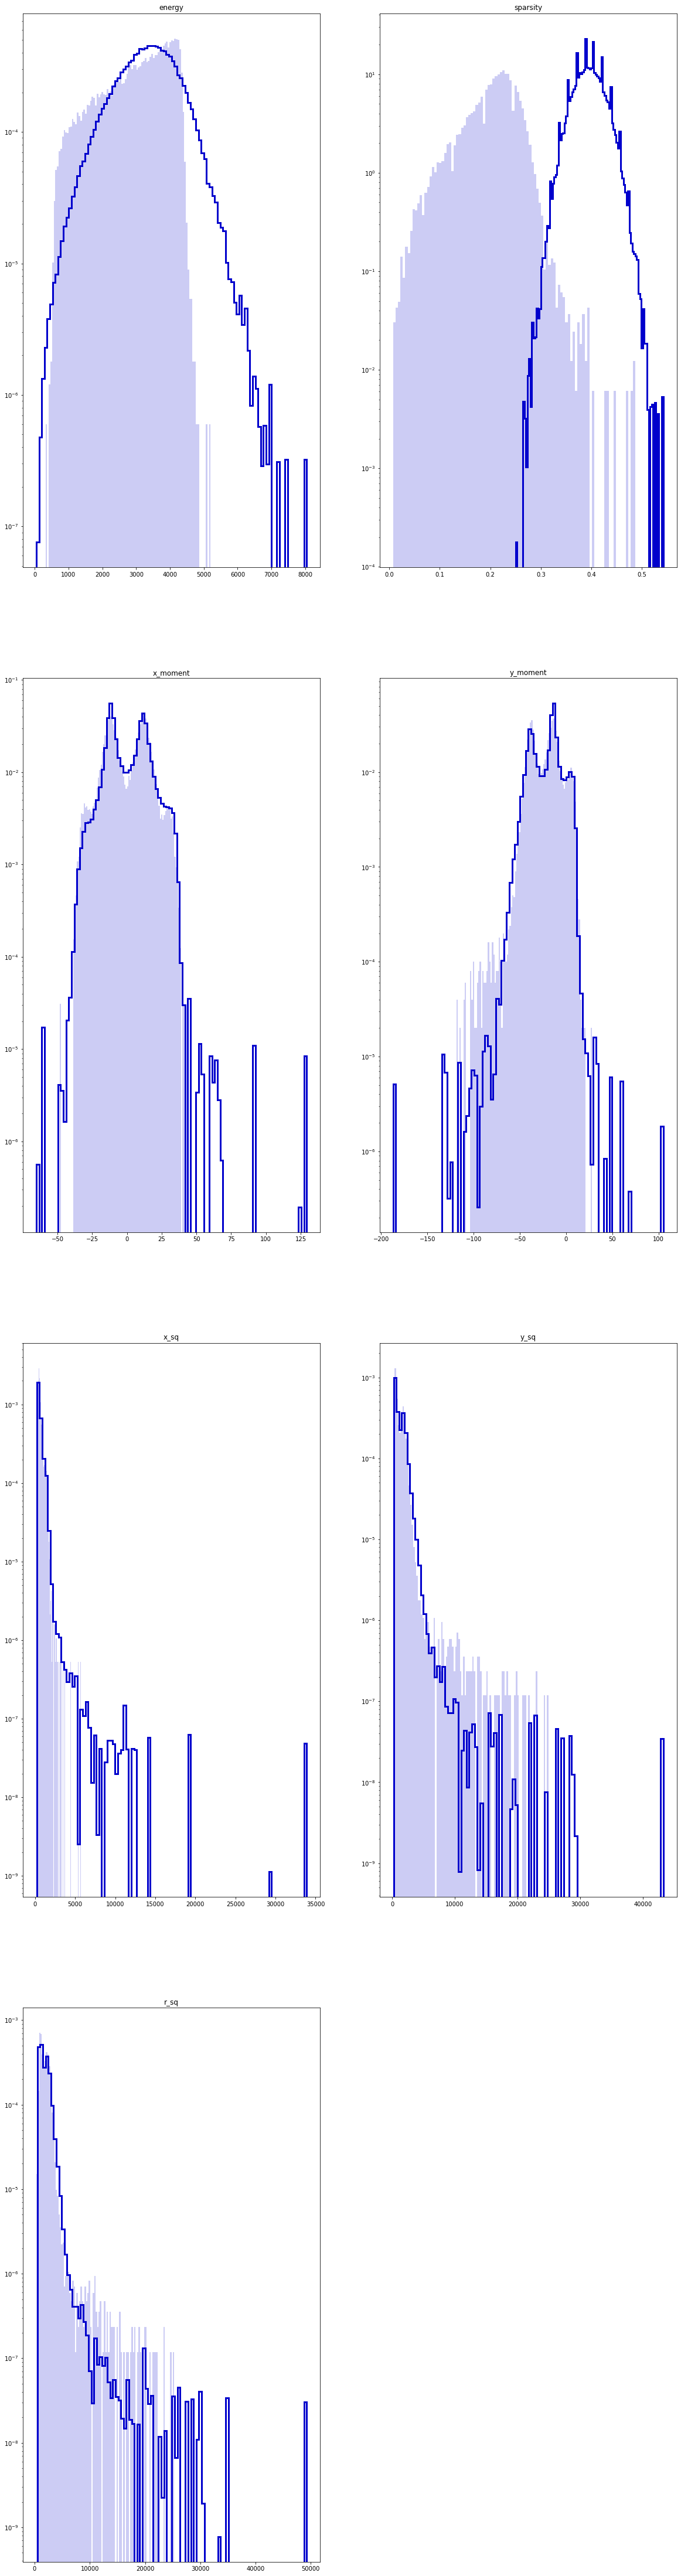

In [72]:
draw_distributions(original, target, D_weights)

## Save model

In [282]:
from datetime import datetime
import pytz

tz = pytz.timezone('Asia/Shanghai') #GMT +8
t = datetime.fromtimestamp(int(time.time()),
    pytz.timezone('Asia/Shanghai')).strftime('%Y-%m-%d_%H:%M:%S')
print(t)
print("Type :",le.inverse_transform(range(nb_classes)))
g_model.save_weights('/content/drive/MyDrive/Data/Model/{}WGANgenerator_{}.hdf5'.format(t,le.inverse_transform(range(nb_classes))),
                                    overwrite=True)

2021-04-26_01:03:08
Type : ['GMM_ECAL']


# GIF

In [ ]:
def create_gif(image_list, gif_name):  
  
    frames = []  
    for image_name in image_list:  
        frames.append(imageio.imread(image_name))  
    # Save them as frames into a gif   
    imageio.mimsave(gif_name, frames, 'GIF', duration = 0.25)  
  
    return 
def find_all_png():

    png_filenames = glob.glob('2D_image*0[0-2]*.png')
    png_filenames = sorted(png_filenames)
    buf=[]
    for png_file in png_filenames:
        buf.append(png_file)
    return buf

buff = find_all_png()
create_gif(buff,'2D_gif.gif' )